In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.svm import SVR
#from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


In [5]:
import pandas as pd
import os

# Update the directory path
directory_path = 'C:\\Users\\Komal'
file_name = 'Bengaluru_House_Data .csv'
file_path = os.path.join(directory_path, file_name)

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [7]:
df.duplicated().sum()

529

In [8]:
df = df.drop_duplicates()
df.shape

(12791, 9)

In [9]:
df.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5328
total_sqft         0
bath              73
balcony          605
price              0
dtype: int64

In [10]:
for col in df.columns:
    print(df[col].value_counts())
    print("*"*20)

Super built-up  Area    8317
Built-up  Area          2398
Plot  Area              1989
Carpet  Area              87
Name: area_type, dtype: int64
********************
Ready To Move    10172
18-May             292
18-Dec             284
18-Apr             269
18-Aug             187
                 ...  
16-Oct               1
15-Dec               1
15-Jun               1
16-Jul               1
14-Jul               1
Name: availability, Length: 81, dtype: int64
********************
Whitefield                        523
Sarjapur  Road                    379
Electronic City                   287
Kanakpura Road                    249
Thanisandra                       229
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1305, dtype: int64
********************
2 BHK         4931
3 BHK        

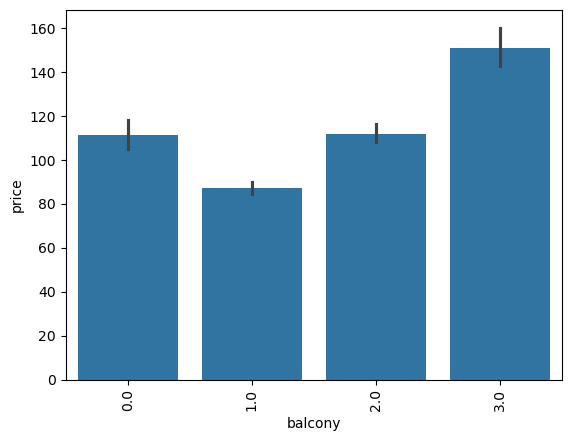

In [11]:
sns.barplot(x=df['balcony'], y=df['price'])
plt.xticks(rotation='vertical')
plt.show()

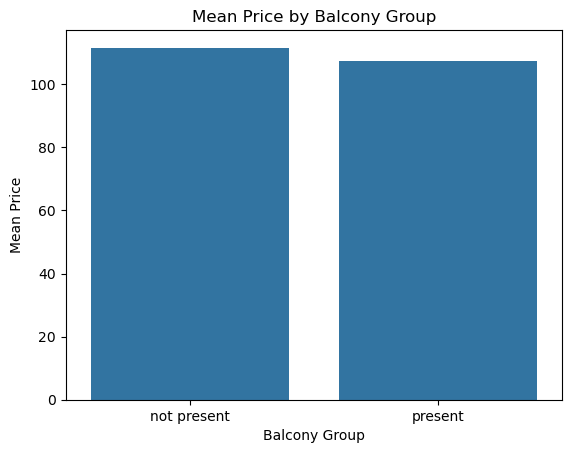

In [12]:
df['grouped_balcony'] = df['balcony'].apply(lambda x: 'present' if x in [1.0, 2.0, 3.0] else 'not present' if x==0.0 else None)
grouped_df = df.groupby('grouped_balcony')['price'].mean().reset_index()

# Plotting the bar plot
sns.barplot(x=grouped_df['grouped_balcony'], y=grouped_df['price'])
plt.xlabel('Balcony Group')
plt.ylabel('Mean Price')
plt.title('Mean Price by Balcony Group')
plt.show()

In [13]:
df['availability'].value_counts()

Ready To Move    10172
18-May             292
18-Dec             284
18-Apr             269
18-Aug             187
                 ...  
16-Oct               1
15-Dec               1
15-Jun               1
16-Jul               1
14-Jul               1
Name: availability, Length: 81, dtype: int64

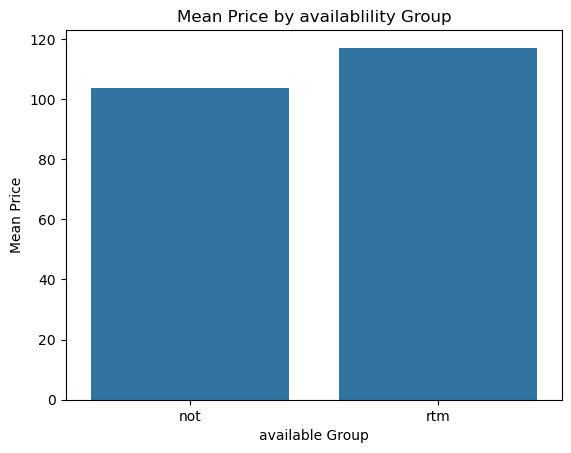

In [14]:
df['grouped_available'] = df['availability'].apply(lambda x: 'rtm' if x=='Ready To Move' else 'not')
grouped_df = df.groupby('grouped_available')['price'].mean().reset_index()

# Plotting the bar plot
sns.barplot(x=grouped_df['grouped_available'], y=grouped_df['price'])
plt.xlabel('available Group')
plt.ylabel('Mean Price')
plt.title('Mean Price by availablility Group')
plt.show()

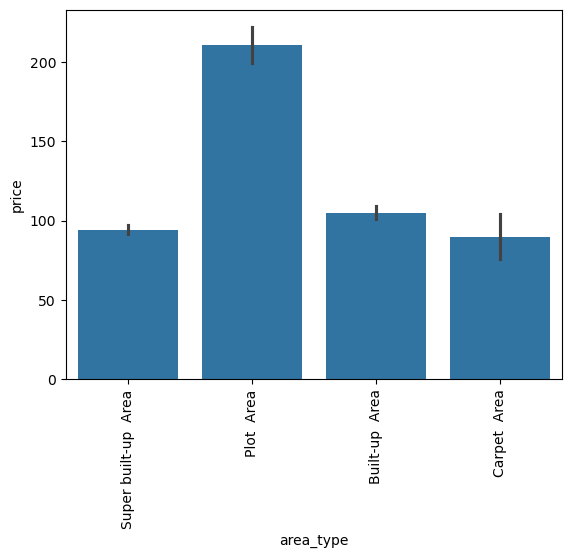

In [15]:
sns.barplot(x=df['area_type'], y=df['price'])
plt.xticks(rotation='vertical')
plt.show()

Availability group and area_type looks like important features as the price vary with them. We will keep them but drop balcony and society columns

In [16]:
df.drop(columns = ['balcony','society', 'grouped_balcony', 'grouped_available'], axis=1, inplace=True)
df.describe()

,bath,price
count,12718.000000,12791.000000
mean,2.708602,114.317646
std,1.357764,151.480310
min,1.000000,8.000000
25%,2.000000,50.000000
50%,2.000000,73.000000
75%,3.000000,121.000000
max,40.000000,3600.000000


In [17]:
df['location'].value_counts()

Whitefield                        523
Sarjapur  Road                    379
Electronic City                   287
Kanakpura Road                    249
Thanisandra                       229
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1305, dtype: int64

In [18]:
df['location'] = df['location'].fillna('Sarjapur  Road')


In [19]:
df['size'].value_counts()

2 BHK         4931
3 BHK         4120
4 Bedroom      824
4 BHK          574
3 Bedroom      535
1 BHK          521
2 Bedroom      314
5 Bedroom      291
6 Bedroom      191
1 Bedroom      104
8 Bedroom       84
7 Bedroom       82
5 BHK           59
9 Bedroom       46
6 BHK           30
7 BHK           17
1 RK            13
10 Bedroom      12
9 BHK            8
8 BHK            5
11 BHK           2
11 Bedroom       2
10 BHK           2
14 BHK           1
13 BHK           1
12 Bedroom       1
27 BHK           1
43 Bedroom       1
16 BHK           1
19 BHK           1
18 Bedroom       1
Name: size, dtype: int64

In [20]:
df['size'] = df['size'].fillna('2 BHK')

In [21]:
df['bath']= df['bath'].fillna(df['bath'].median())


In [22]:
df['bhk'] = df['size'].str.split(" ").str[0].astype(int)

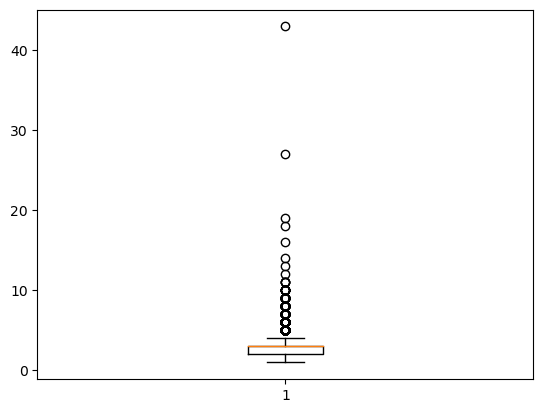

In [23]:
plt.boxplot(df['bhk'])
plt.show()

In [24]:
df[df['bhk']>20]

,area_type,availability,location,size,total_sqft,bath,price,bhk
1718,Super built-up Area,Ready To Move,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Plot Area,Ready To Move,Munnekollal,43 Bedroom,2400,40.0,660.0,43


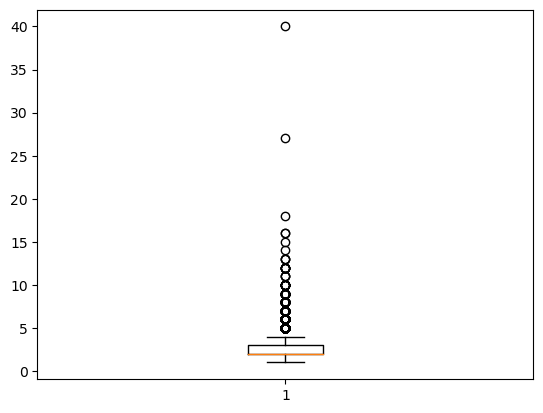

In [25]:
plt.boxplot(df['bath'])
plt.show()

In [26]:
#checking problamatic str values (ranges defined) in the total_sqft column

def check_str(val):
    try:
        float(val) 
    except:
        return True
    return False    

df[df['total_sqft'].apply(check_str)]

,area_type,availability,location,size,total_sqft,bath,price,bhk
30,Super built-up Area,19-Dec,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Built-up Area,20-Feb,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Built-up Area,18-Oct,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Super built-up Area,18-Mar,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,Super built-up Area,19-Mar,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
...,...,...,...,...,...,...,...,...
12975,Super built-up Area,20-Aug,Whitefield,2 BHK,850 - 1060,2.0,38.190,2
12990,Super built-up Area,18-May,Talaghattapura,3 BHK,1804 - 2273,3.0,122.000,3
13059,Super built-up Area,Ready To Move,Harlur,2 BHK,1200 - 1470,2.0,72.760,2
13240,Super built-up Area,Ready To Move,Devanahalli,1 BHK,1020 - 1130,2.0,52.570,1


In [27]:
def convert_range(x):
    temp = x.split('-')
    if len(temp)==2:
        return (float(temp[0])+float(temp[1]))/2
    try:
        return float(x)
    except:
        return None
        
df['total_sqft'] = df['total_sqft'].apply(convert_range)

In [28]:
df.isna().sum()

area_type        0
availability     0
location         0
size             0
total_sqft      46
bath             0
price            0
bhk              0
dtype: int64

In [29]:
df = df.dropna()

In [30]:
df.isna().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
price           0
bhk             0
dtype: int64

feature engineering

Let's make a feature with price and total_sqft which we would be using to remove outliers



In [31]:
df['price_per_sqft'] = df['price']*100000/df['total_sqft']

In [32]:
df['price_per_sqft']

0         3699.810606
1         4615.384615
2         4305.555556
3         6245.890861
4         4250.000000
             ...     
13314     6530.612245
13315     6689.834926
13316    11111.111111
13317     5258.545136
13318    10407.336319
Name: price_per_sqft, Length: 12745, dtype: float64

In [33]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12745.00000,12745.000000,12745.000000,12745.000000,1.274500e+04
mean,1569.60368,2.703099,114.207350,2.815771,8.022896e+03
std,1259.83493,1.352340,151.591687,1.308425,1.086134e+05
min,1.00000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.00000,2.000000,50.000000,2.000000,4.298559e+03
50%,1280.00000,2.000000,73.000000,3.000000,5.482304e+03
75%,1691.00000,3.000000,120.000000,3.000000,7.398708e+03
max,52272.00000,40.000000,3600.000000,43.000000,1.200000e+07


In [34]:
df.location = df.location.apply(lambda x : x.strip())
loc_val = df['location'].value_counts()
loc_val

Whitefield                        522
Sarjapur  Road                    380
Electronic City                   289
Kanakpura Road                    247
Thanisandra                       231
                                 ... 
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
Kannur                              1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1288, dtype: int64

In [35]:
to_be_others = loc_val[loc_val.values<=10].index

In [36]:
df['location'] = df['location'].apply(lambda x: 'others' if x in to_be_others else x)

df['location'].value_counts()

others              2924
Whitefield           522
Sarjapur  Road       380
Electronic City      289
Kanakpura Road       247
                    ... 
Doddaballapur         11
LB Shastri Nagar      11
Tindlu                11
HAL 2nd Stage         11
Banjara Layout        11
Name: location, Length: 233, dtype: int64

In [37]:
to_be_others

Index(['Marsur', 'Thyagaraja Nagar', 'BEML Layout', 'Narayanapura',
       'Gunjur Palya', 'Pattandur Agrahara', 'Naganathapura',
       'Nagappa Reddy Layout', 'BTM 1st Stage', '1st Block Koramangala',
       ...
       'Maruthi Extension', 'Okalipura', 'Old Town', 'Vasantapura main road',
       'Bapuji Layout', '1st Stage Radha Krishna Layout',
       'BEML Layout 5th stage', 'Kannur', 'singapura paradise',
       'Abshot Layout'],
      dtype='object', length=1056)

Outlier detection and removal

In [38]:
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12745.00000,12745.000000,12745.000000,12745.000000,1.274500e+04
mean,1569.60368,2.703099,114.207350,2.815771,8.022896e+03
std,1259.83493,1.352340,151.591687,1.308425,1.086134e+05
min,1.00000,1.000000,8.000000,1.000000,2.678298e+02
25%,1100.00000,2.000000,50.000000,2.000000,4.298559e+03
50%,1280.00000,2.000000,73.000000,3.000000,5.482304e+03
75%,1691.00000,3.000000,120.000000,3.000000,7.398708e+03
max,52272.00000,40.000000,3600.000000,43.000000,1.200000e+07


In [39]:
df = df[df['total_sqft']/df['bhk']>=300]
df.describe()

,total_sqft,bath,price,bhk,price_per_sqft
count,12011.000000,12011.000000,12011.000000,12011.000000,12011.000000
mean,1606.223870,2.571643,113.252382,2.660644,6363.396694
std,1283.874933,1.090077,154.815223,0.988055,4226.681217
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1117.000000,2.000000,49.975000,2.000000,4250.000000
50%,1306.000000,2.000000,70.000000,3.000000,5330.490405
75%,1715.000000,3.000000,120.000000,3.000000,6967.569041
max,52272.000000,16.000000,3600.000000,16.000000,176470.588235


In [40]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, val in df.groupby('location'):
        m = np.mean(val.price_per_sqft)
        std = np.std(val.price_per_sqft)

        gen_df = val[(val.price_per_sqft>=std-m) & (val.price_per_sqft<=std+m)]
        df_out = pd.concat([df_out,gen_df], ignore_index=True)

    return df_out

df = remove_pps_outliers(df)
df.describe()


,total_sqft,bath,price,bhk,price_per_sqft
count,10665.000000,10665.000000,10665.000000,10665.000000,10665.000000
mean,1536.625724,2.476981,90.165037,2.580684,5568.990001
std,1239.533013,1.001621,85.894598,0.923703,2285.591819
min,300.000000,1.000000,8.440000,1.000000,267.829813
25%,1101.000000,2.000000,48.000000,2.000000,4121.750159
50%,1285.000000,2.000000,65.940000,2.000000,5084.745763
75%,1650.000000,3.000000,100.000000,3.000000,6370.370370
max,52272.000000,16.000000,2200.000000,16.000000,24509.803922


In [41]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

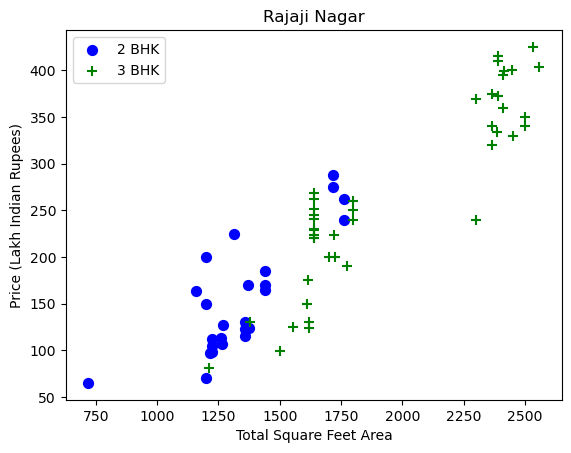

In [42]:
plot_scatter_chart(df,"Rajaji Nagar")

In [43]:
df.shape

(10665, 9)

In [44]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df = remove_bhk_outliers(df)
df.shape


(7736, 9)

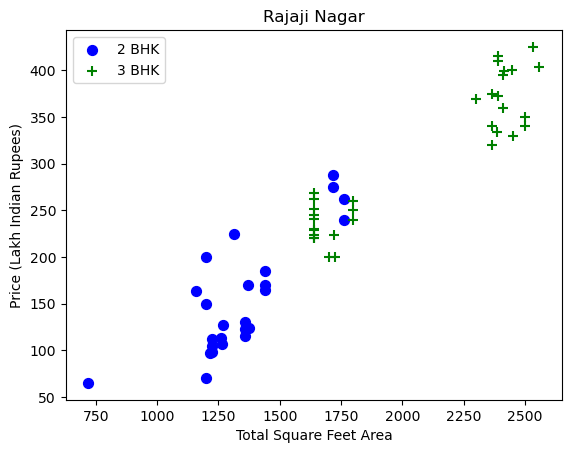

In [45]:
plot_scatter_chart(df,"Rajaji Nagar")

Let's drop unwanted columns - size, price_per_sqft

In [46]:
df.drop(['size', 'price_per_sqft'], axis=1, inplace= True)

In [47]:
df.head()

,area_type,availability,location,total_sqft,bath,price,bhk
0,Super built-up Area,20-May,1st Block Jayanagar,2850.0,4.0,428.0,4
1,Super built-up Area,18-Jun,1st Block Jayanagar,1630.0,3.0,194.0,3
2,Super built-up Area,Ready To Move,1st Block Jayanagar,1875.0,2.0,235.0,3
3,Super built-up Area,Ready To Move,1st Block Jayanagar,1000.0,3.0,60.0,2
4,Built-up Area,15-Dec,1st Block Jayanagar,1200.0,2.0,130.0,3


In [48]:
df['area_type'].value_counts()

Super built-up  Area    5567
Built-up  Area          1478
Plot  Area               644
Carpet  Area              47
Name: area_type, dtype: int64

In [49]:
df['availability'] = df['availability'].apply(lambda x: 1 if x=='Ready To Move' else 0)

In [50]:
df = df[df.bath<df.bhk+2]

Cleaned data

In [51]:
df.head()

,area_type,availability,location,total_sqft,bath,price,bhk
0,Super built-up Area,0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,Super built-up Area,0,1st Block Jayanagar,1630.0,3.0,194.0,3
2,Super built-up Area,1,1st Block Jayanagar,1875.0,2.0,235.0,3
3,Super built-up Area,1,1st Block Jayanagar,1000.0,3.0,60.0,2
4,Built-up Area,0,1st Block Jayanagar,1200.0,2.0,130.0,3


In [52]:
df.describe()

,availability,total_sqft,bath,price,bhk
count,7651.000000,7651.000000,7651.000000,7651.000000,7651.000000
mean,0.786172,1489.046531,2.424389,96.110947,2.500719
std,0.410034,884.916801,0.966566,87.856816,0.938971
min,0.000000,300.000000,1.000000,8.440000,1.000000
25%,1.000000,1091.500000,2.000000,50.000000,2.000000
50%,1.000000,1259.000000,2.000000,72.000000,2.000000
75%,1.000000,1665.000000,3.000000,110.000000,3.000000
max,1.000000,30000.000000,16.000000,2200.000000,16.000000


<Axes: >

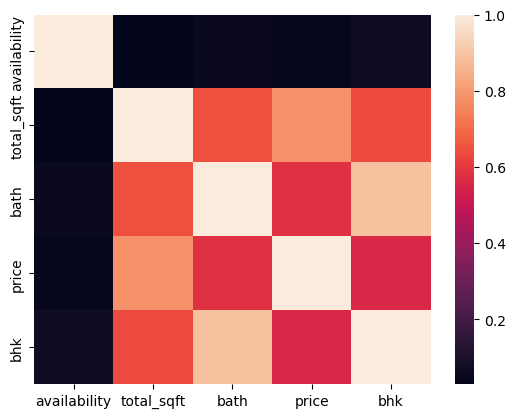

In [53]:
df.corr(numeric_only=True)['price']
sns.heatmap(df.corr(numeric_only=True))

In [54]:
X = df.drop(columns = ['price'])
y = df['price']

Model building

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [56]:
print(X_train.shape)
print(X_test.shape)

(6120, 6)
(1531, 6)


In [57]:
X_train

,area_type,availability,location,total_sqft,bath,bhk
9499,Plot Area,1,others,1200.0,4.0,4
7195,Super built-up Area,1,Tumkur Road,1066.0,2.0,2
4562,Super built-up Area,1,Kenchenahalli,1280.0,2.0,3
1321,Super built-up Area,0,Bommanahalli,1250.0,3.0,3
4612,Super built-up Area,0,Kengeri,416.0,1.0,1
...,...,...,...,...,...,...
6050,Super built-up Area,1,Rajaji Nagar,2409.0,3.0,3
3972,Super built-up Area,0,Kadugodi,1314.0,2.0,2
1979,Super built-up Area,1,Electronic City,1070.0,2.0,2
3189,Super built-up Area,0,Hennur Road,1232.0,2.0,2


In [59]:

step1 = ColumnTransformer(transformers=[
                         ('col_tnf', OneHotEncoder(sparse_output=False, drop='first'),[0,2])
                 ], remainder='passthrough')
step2 = StandardScaler() 
step3 = SVR()

pipe = Pipeline([
    ('step1', step1),
    ('step2', step2),
    ('step3', step3)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("R2 score ", r2_score(y_test, y_pred))
print("MAE score ", mean_absolute_error(y_test, y_pred))


R2 score  0.31486826625338016
MAE score  31.353958981535918
